# Project Title: Evaluating Dimensionality Reduction for High-Dimensional Image Classification

## Setup & Data Loading

In [319]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cudf
import cuml
import cupy as cp
import pandas as pd

SEED = 17
THRESHOLD = 0.9

In [320]:
df_train = cudf.read_csv("fashion-mnist_train.csv")
df_test = cudf.read_csv("fashion-mnist_test.csv")

In [321]:
print(f"Train df has shape of {df_train.shape}")
print(f"Test df has shape of {df_test.shape}")

Train df has shape of (60000, 785)
Test df has shape of (10000, 785)


## Data Preprocessing

In [322]:
X_train_gpu = df_train.drop(columns="label")
y_train_gpu = df_train["label"]

X_test_gpu = df_test.drop(columns="label")
y_test_gpu = df_test["label"]

In [323]:
from cuml.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled_gpu = scaler.fit_transform(X_train_gpu)
X_test_scaled_gpu = scaler.transform(X_test_gpu)

## Part 1: Unsupervised Reduction with PCA

In [324]:
pca = cuml.PCA(n_components=None)
pca.fit(X_train_scaled_gpu)

[2025-07-29 14:09:00.898] [CUML] [warning] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


PCA()

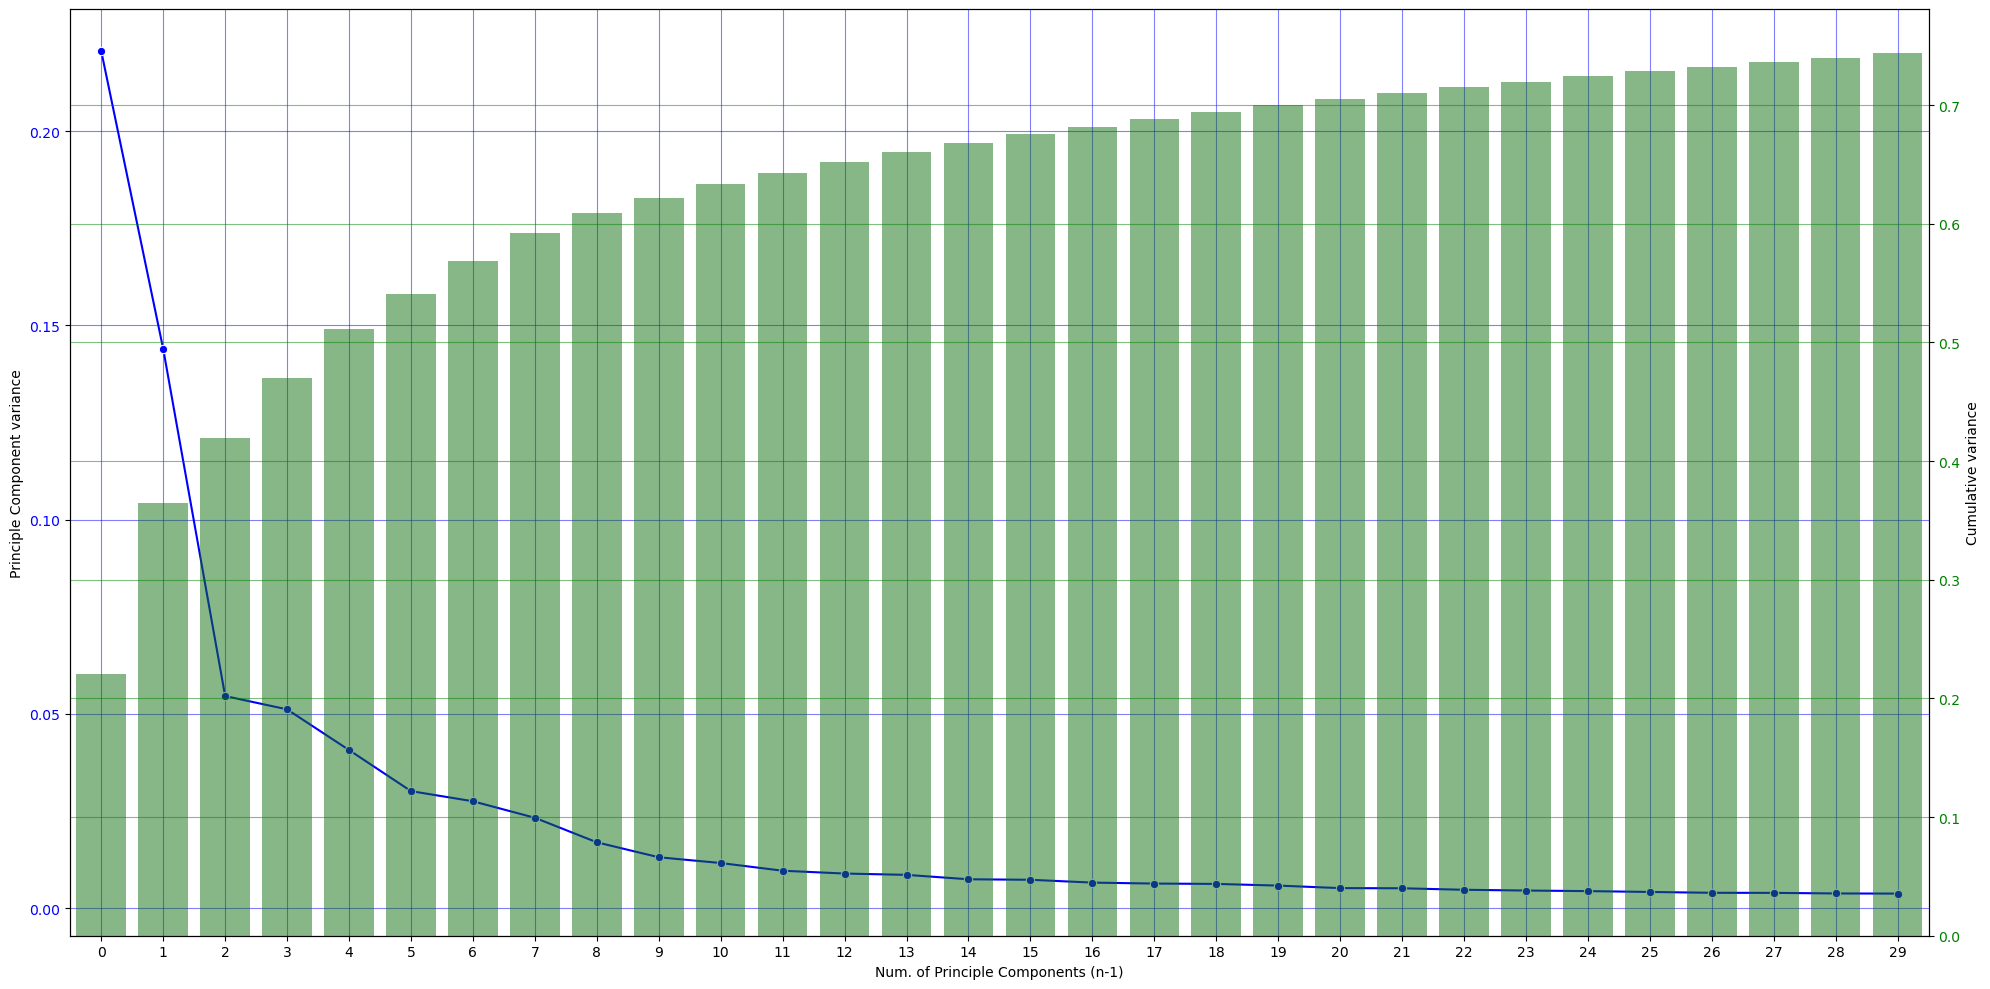

In [325]:
cum_variance_gpu = cp.cumsum(pca.explained_variance_ratio_.values)
pca_variance_gpu = pca.explained_variance_ratio_

df_pca_gpu = cudf.DataFrame(
    data={
        "Cumulative Variance": cum_variance_gpu,
        "Principle Component Variance": pca_variance_gpu,
    }
)
df_pca_cpu = df_pca_gpu.to_pandas()

num_components_to_plot = 30
fig, ax1 = plt.subplots(figsize=(20, 10))
line_color = "blue"
bar_color = "green"
sns.lineplot(
    data=df_pca_cpu["Principle Component Variance"][:num_components_to_plot],
    marker="o",
    ax=ax1,
    color=line_color,
)
ax2 = ax1.twinx()
sns.barplot(
    data=df_pca_cpu["Cumulative Variance"][:num_components_to_plot],
    alpha=0.5,
    ax=ax2,
    color=bar_color,
)
ax1.set_ylabel("Principle Component variance")
ax1.tick_params(axis="y", labelcolor=line_color)
ax2.tick_params(axis="y", labelcolor=bar_color)
ax2.set_ylabel("Cumulative variance")
ax1.set_xlabel("Num. of Principle Components (n-1)")
ax1.grid(alpha=0.5, color=line_color)
ax2.grid(alpha=0.5, color=bar_color)
plt.tight_layout()

In [326]:
thresh_idx = cp.where(cum_variance_gpu >= THRESHOLD)[0][0].get()
print(
    f"Elbow point at component 3 with cumulative explained variance of {round(df_pca_cpu['Cumulative Variance'][2], 2)}."
)
print(
    f"Component {thresh_idx + 1} above threshold with cumulative explained variance of {round(df_pca_cpu.iloc[thresh_idx]['Cumulative Variance'], 2)}."
)

Elbow point at component 3 with cumulative explained variance of 0.42.
Component 137 above threshold with cumulative explained variance of 0.9.


In [327]:
pca_new = cuml.PCA(n_components=2)
X_train_pca_gpu = pca_new.fit_transform(X_train_scaled_gpu)
X_test_pca_gpu = pca_new.transform(X_test_scaled_gpu)

In [328]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary(X, y, classifier, random_state, n=None):
    total_n = len(X)
    rng = np.random.default_rng(seed=random_state)
    rand_idx = rng.choice(total_n, min(n, total_n), replace=False)
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[0].min(), X[0].max()), np.linspace(X[1].min(), X[1].max())
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(classifier.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)

    display.plot()
    display.ax_.scatter(
        X[0].to_numpy()[rand_idx],
        X[1].to_numpy()[rand_idx],
        c=y.to_numpy()[rand_idx],
        edgecolor="black",
        alpha=0.7,
        s=40,
    )

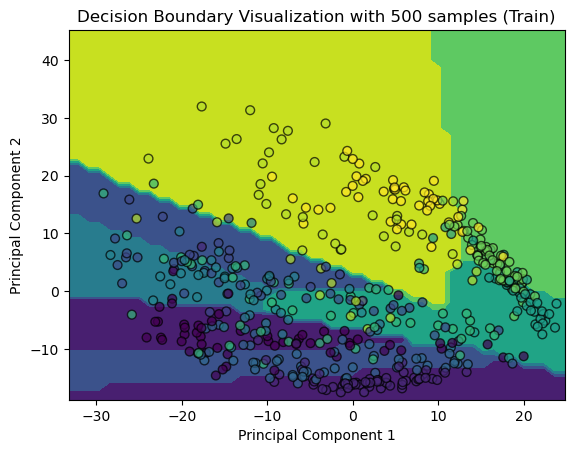

In [329]:
lr_pca = cuml.LogisticRegression().fit(X_train_pca_gpu, y_train_gpu)
n_samples = 500
plot_decision_boundary(
    X=X_train_pca_gpu, y=y_train_gpu, classifier=lr_pca, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Train)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

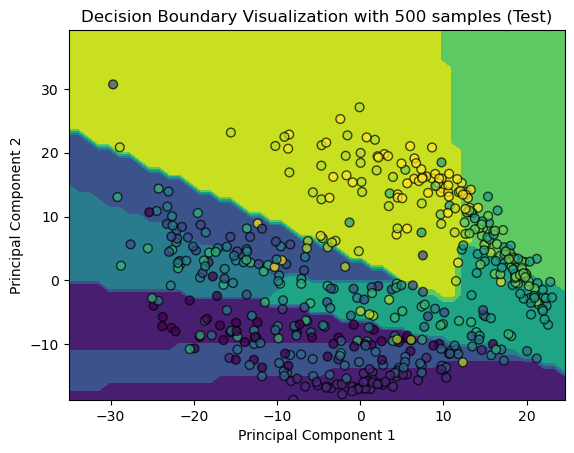

In [330]:
n_samples = 500
plot_decision_boundary(
    X=X_test_pca_gpu, y=y_test_gpu, classifier=lr_pca, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Test)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Part 2: Supervised Reduction with LDA

In [331]:
X_train_scaled_cpu = X_train_scaled_gpu.to_numpy()
X_test_scaled_cpu = X_test_scaled_gpu.to_numpy()
y_train_cpu = y_train_gpu.to_numpy()
y_test_cpu = y_test_gpu.to_numpy()

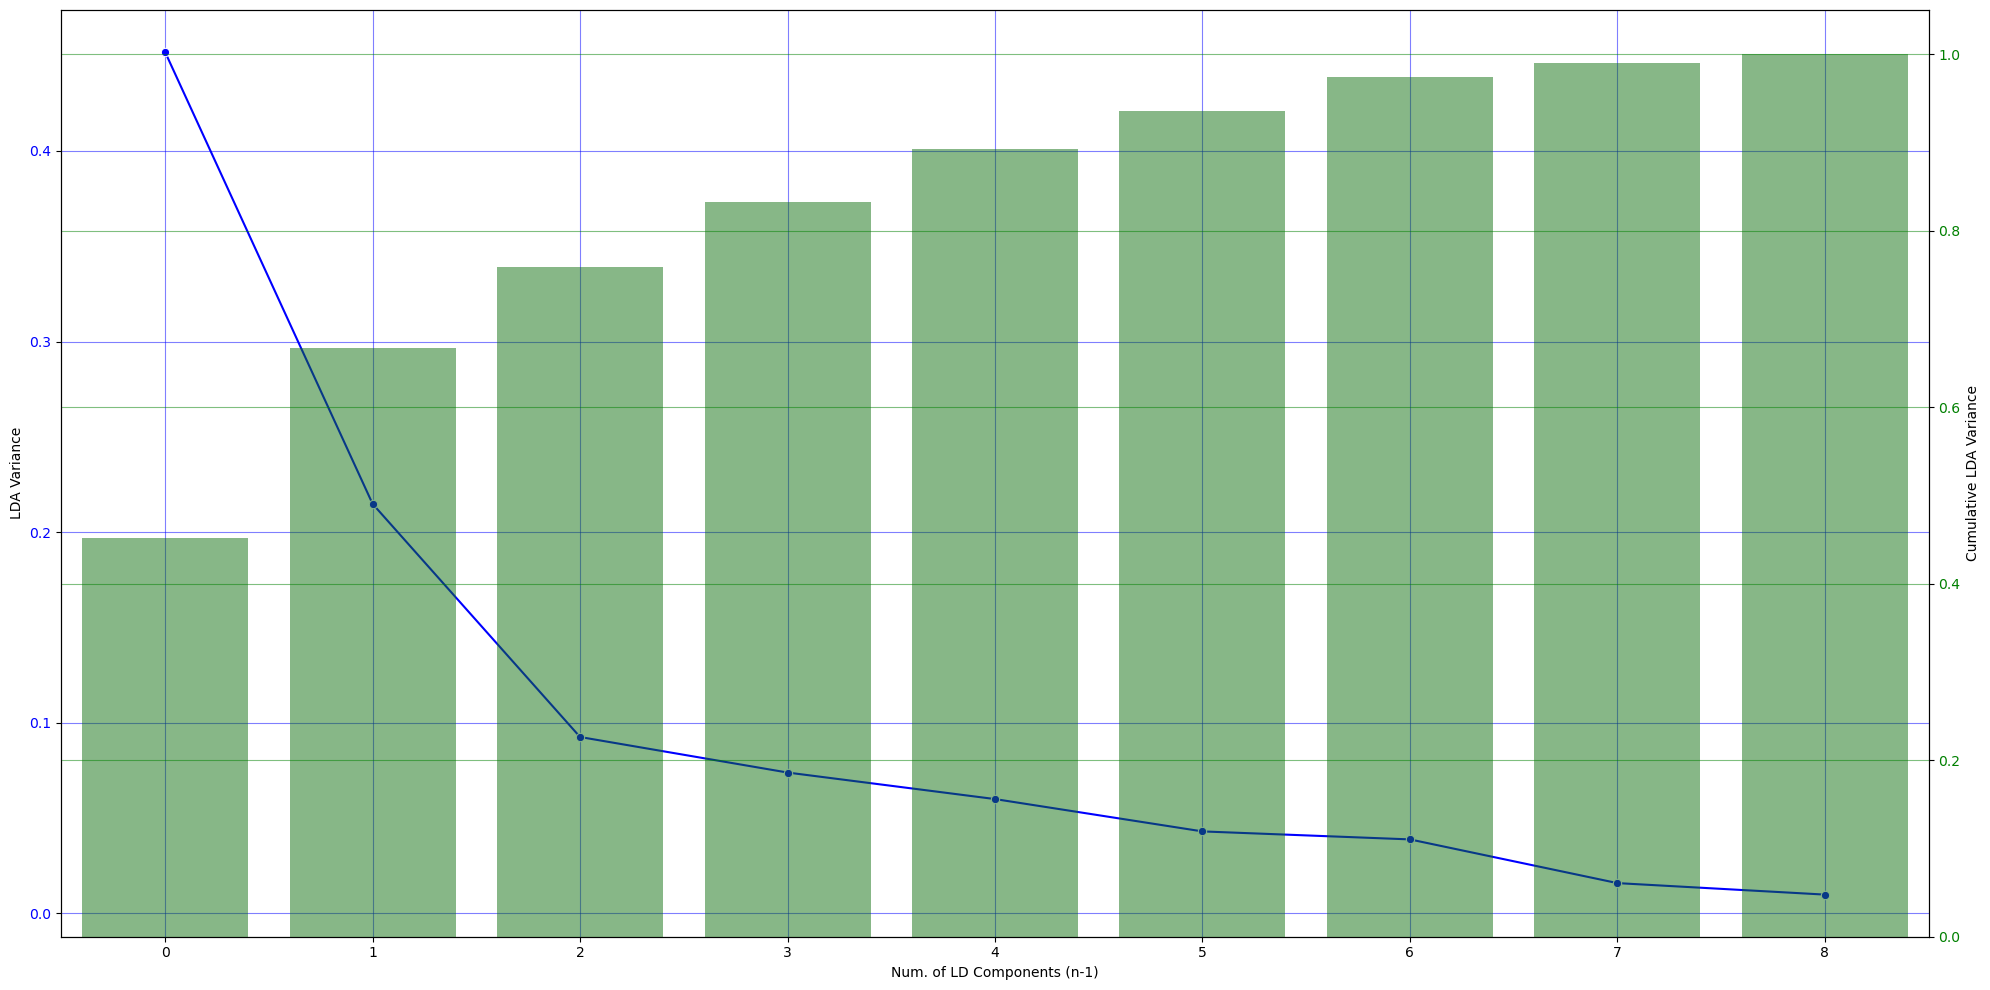

In [332]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=None)
lda.fit(X=X_train_scaled_cpu, y=y_train_cpu)

lda_variance_cpu = lda.explained_variance_ratio_
lda_cum_variance_cpu = np.cumsum(lda_variance_cpu)

df_lda_cpu = pd.DataFrame(
    data={
        "Cumulative LDA Variance": lda_cum_variance_cpu,
        "LDA Variance": lda_variance_cpu,
    }
)

fig, ax1 = plt.subplots(figsize=(20, 10))
line_color = "blue"
bar_color = "green"
sns.lineplot(
    data=df_lda_cpu["LDA Variance"][:num_components_to_plot],
    marker="o",
    ax=ax1,
    color=line_color,
)
ax2 = ax1.twinx()
sns.barplot(
    data=df_lda_cpu["Cumulative LDA Variance"][:num_components_to_plot],
    alpha=0.5,
    ax=ax2,
    color=bar_color,
)
ax1.set_ylabel("LDA Variance")
ax1.tick_params(axis="y", labelcolor=line_color)
ax2.tick_params(axis="y", labelcolor=bar_color)
ax2.set_ylabel("Cumulative LDA Variance")
ax1.set_xlabel("Num. of LD Components (n-1)")
ax1.grid(alpha=0.5, color=line_color)
ax2.grid(alpha=0.5, color=bar_color)
plt.tight_layout()

In [334]:
thresh_idx = np.where(lda_cum_variance_cpu >= THRESHOLD)[0][0]
print(
    f"Elbow point at component 3 with cumulative explained variance of {round(df_lda_cpu['Cumulative LDA Variance'][2], 2)}."
)
print(
    f"Component {thresh_idx + 1} above threshold with cumulative explained variance of {round(df_lda_cpu.iloc[thresh_idx]['Cumulative LDA Variance'], 2)}."
)

Elbow point at component 3 with cumulative explained variance of 0.76.
Component 6 above threshold with cumulative explained variance of 0.94.


In [289]:
lda_new = LDA(n_components=2)
X_train_lda_cpu = lda_new.fit_transform(X=X_train_scaled_cpu, y=y_train_cpu)
X_test_lda_cpu = lda_new.transform(X_test_scaled_cpu)

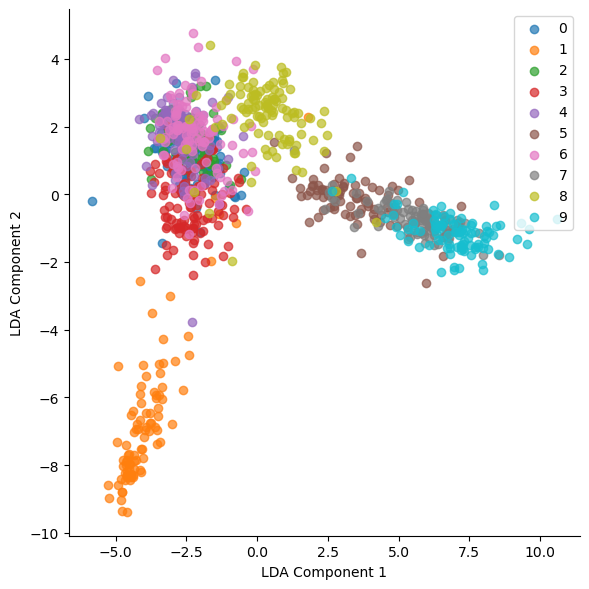

In [ ]:
df_lda_new = pd.DataFrame(
    X_train_lda_cpu, columns=["LDA Component 1", "LDA Component 2"]
)
df_lda_new["Class"] = y_train_cpu

n_samples = 1000
total_n = len(df_lda_new)
rng = np.random.default_rng(seed=SEED)
rand_idx = rng.choice(total_n, min(n_samples, total_n), replace=False)
sns.FacetGrid(df_lda_new.iloc[rand_idx], hue="Class", height=6).map(
    plt.scatter, "LDA Component 1", "LDA Component 2", alpha=0.7
)

plt.legend(loc="upper right")
plt.tight_layout()

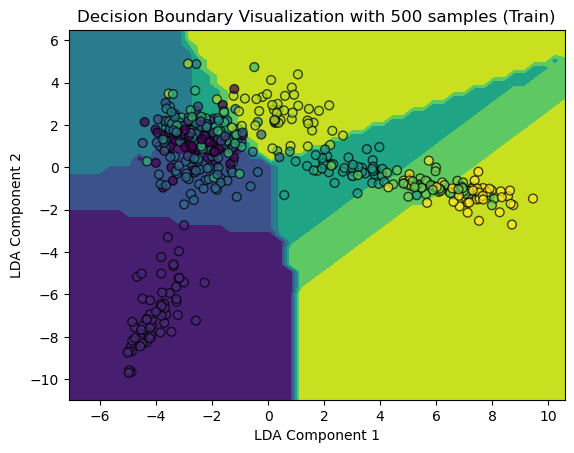

In [ ]:
X_train_lda_gpu = cudf.DataFrame(X_train_lda_cpu)

lr_lda = cuml.LogisticRegression().fit(X_train_lda_gpu, y_train_gpu)

n_samples = 500
plot_decision_boundary(
    X=X_train_lda_gpu, y=y_train_gpu, classifier=lr_lda, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Train)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()

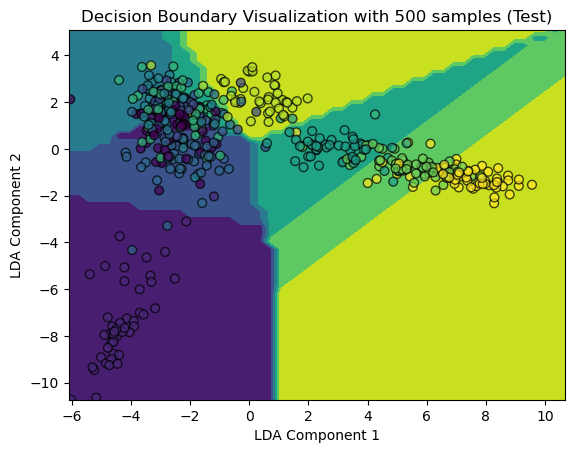

In [ ]:
X_test_lda_gpu = cudf.DataFrame(X_test_lda_cpu)

n_samples = 500
plot_decision_boundary(
    X=X_test_lda_gpu, y=y_test_gpu, classifier=lr_lda, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Test)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()

## Part 3: Performance Comparison

## Part 4: Nonlinear Visualization with t-SNE

## Conclusion